In [1]:
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('data/step3_features_summary.csv', parse_dates=['Time'], index_col='Time')
df.head()

,GDP_growth,Spending_to_GDP_diff,Unemployment_diff,Rent_income_diff,Inflation_diff,PPI_diff_2
Time,,,,,,
1997-12-31,4.487859,-1.155073,-0.7,-0.016114,1.25167,-1.94017
1998-03-31,4.855286,-1.078558,-0.5,-0.024101,0.98445,-2.10186
1998-06-30,4.095967,-1.002043,-0.5,-0.027875,1.08290,-0.88027
1998-09-30,4.097735,-0.925527,-0.3,-0.025923,1.08290,-0.55690
1998-12-31,4.879111,-0.849012,-0.3,-0.016616,1.05477,-0.26948


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 94 entries, 1997-12-31 to 2021-03-31
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   GDP_growth            94 non-null     float64
 1   Spending_to_GDP_diff  94 non-null     float64
 2   Unemployment_diff     94 non-null     float64
 3   Rent_income_diff      94 non-null     float64
 4   Inflation_diff        94 non-null     float64
 5   PPI_diff_2            94 non-null     float64
dtypes: float64(6)
memory usage: 5.1 KB


In [4]:
df.describe()

,GDP_growth,Spending_to_GDP_diff,Unemployment_diff,Rent_income_diff,Inflation_diff,PPI_diff_2
count,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000
mean,2.091029,0.061808,0.118085,-0.010401,1.800067,-0.068036
std,2.163947,1.066278,1.392064,0.024057,0.962070,4.748891
min,-9.032775,-1.819629,-1.400000,-0.136863,-1.501860,-18.952680
25%,1.504706,-0.559768,-0.600000,-0.022274,1.263270,-2.061437
50%,2.324297,-0.091719,-0.300000,-0.010085,1.802350,0.035915
75%,3.296804,0.438832,0.300000,0.001084,2.324028,2.506140
max,5.297738,3.439162,7.500000,0.046785,4.658890,11.928510


## Cointegration test

In [5]:
# second term represents the order of null hypothesis, 0 implies it is a constant term
# third term represents lagged difference terms used when computing the estimator, 1 implies single lagged difference term
coint_johansen(df, 0, 1).eig

array([0.41142178, 0.32851605, 0.17024525, 0.12179778, 0.09670481,
       0.09123083])

### Trace statistics
Identify whether the sum of eigenvalues is 0.

Null hypothesis: sum of eigenvalues is 0, series are not cointegrated

The trace statistics below tells us that most coeifficients (except r <= 2) can reject null hypothesis at 95% or above, which means the series are cointegrated. However, it also means that it may be possible to form a linear combination with only 2 time series (r = 2) rather than requiring all 6 time series to form a cointegrating prediction.

In [6]:
stat = coint_johansen(df, 0, 1).trace_stat
crit = coint_johansen(df, 0, 1).trace_stat_crit_vals
coint_trace = pd.DataFrame(crit, columns=['cv=90%', 'cv=95%', 'cv=99%'])
coint_trace['trace stat'] = stat.tolist()
coint_trace['r'] = ['r = 0', 'r <= 1', 'r <= 2', 'r <= 3', 'r <= 4', 'r <= 5']
coint_trace

,cv=90%,cv=95%,cv=99%,trace stat,r
0,91.1090,95.7542,104.9637,132.680942,r = 0
1,65.8202,69.8189,77.8202,83.916761,r <= 1
2,44.4929,47.8545,54.6815,47.276366,r <= 2
3,27.0669,29.7961,35.4628,30.106856,r <= 3
4,13.4294,15.4943,19.9349,18.158044,r <= 4
5,2.7055,3.8415,6.6349,8.801103,r <= 5


### Eigen statistics
Identify how strongly cointegrated the series are or how strong is the tendency to mean revert.

Null hypothesis: time series are not cointegrated

When the coefficients are r <= 0, 1 and 5, the null hypothesis is rejected at 99% and the time series are cointegrated. Since r <= 2, 3, and 4 are not able to reject the null hypothesis. It may tell us that only 1 time series is needed to form cointegration with the target time series until we reach r <= 5.

In [7]:
stat = coint_johansen(df, 0, 1).max_eig_stat
crit = coint_johansen(df, 0, 1).max_eig_stat_crit_vals
coint_eig = pd.DataFrame(crit, columns=['cv=90%', 'cv=95%', 'cv=99%'])
coint_eig['eig stat'] = stat.tolist()
coint_eig['r'] = ['r = 0', 'r <= 1', 'r <= 2', 'r <= 3', 'r <= 4', 'r <= 5']
coint_eig

,cv=90%,cv=95%,cv=99%,eig stat,r
0,37.2786,40.0763,45.8662,48.764181,r = 0
1,31.2379,33.8777,39.3693,36.640395,r <= 1
2,25.1236,27.5858,32.7172,17.169509,r <= 2
3,18.8928,21.1314,25.8650,11.948812,r <= 3
4,12.2971,14.2639,18.5200,9.356941,r <= 4
5,2.7055,3.8415,6.6349,8.801103,r <= 5


## Split data and modeling

In [8]:
# we will split the data and use the last 8 quarters as the test set for prediction
nobs = 4
df_train, df_test = df[0:-nobs], df[-nobs:]

In [9]:
model = VAR(df_train)
results = model.fit(maxlags=12, ic='aic')
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 03, Aug, 2021
Time:                     14:40:04
--------------------------------------------------------------------
No. of Equations:         6.00000    BIC:                   -66.0466
Nobs:                     78.0000    HQIC:                  -73.9827
Log likelihood:           2865.87    FPE:                3.72855e-31
AIC:                     -79.2804    Det(Omega_mle):     1.73808e-33
--------------------------------------------------------------------
Results for equation GDP_growth
                              coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------------
const                            1.358866         1.507464            0.901           0.367
L1.GDP_growth                   -0.859822         0.410261           -2.096           0.036
L1.Spending

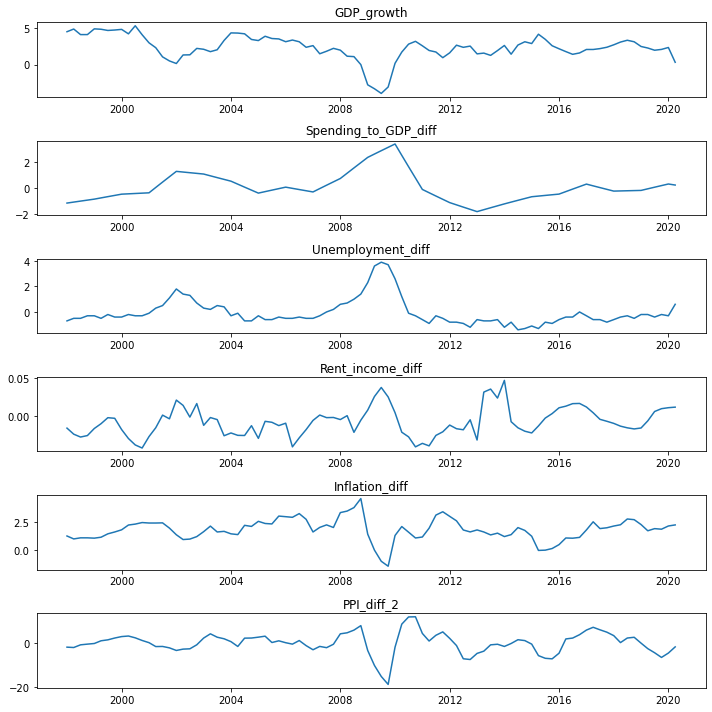

In [10]:
# Plot input time series
results.plot()
plt.tight_layout()
plt.show()

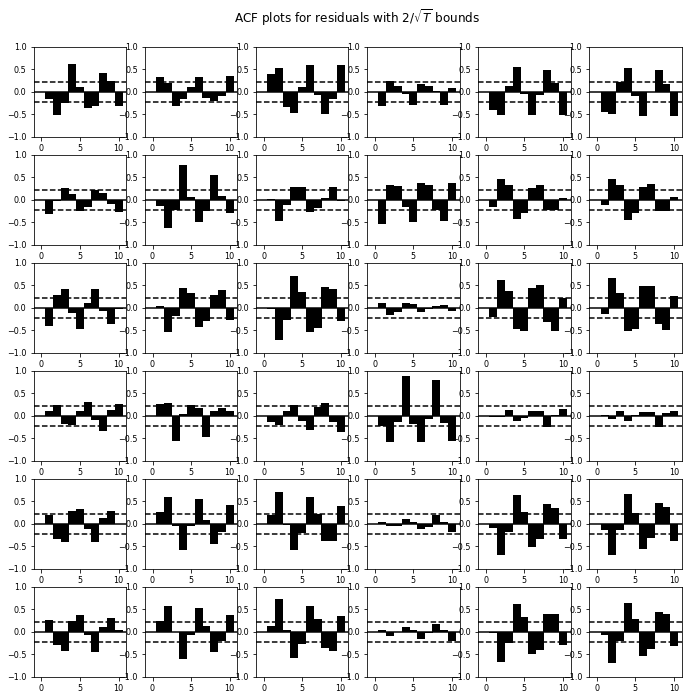

In [11]:
# Plot time series autocorrelation function
results.plot_acorr()
plt.show()

### Lag order selection

The max lag of 10 provides the lowest AIC score. Hence, 10 is selected and used to forecast 8 steps ahead.

In [12]:
model.select_order(12)
results = model.fit(maxlags=12, ic='aic')
lag_order = results.k_ar

In [13]:
# forecast 8 steps ahead
forecast_steps = 8
forecast = results.forecast(df.values[-lag_order:], forecast_steps)
forecast

array([[-3.30566215e+01,  4.03653323e+00,  3.95530928e+00,
        -1.11994389e-01, -2.50957541e+00,  2.85576839e+01],
       [ 3.44174951e+00,  1.72729822e+00,  1.65998806e+00,
         3.26817676e-02,  6.73509266e+00,  2.22449451e+01],
       [ 6.13508288e+00, -7.24983235e-01, -3.57076706e+00,
        -4.82228026e-02,  8.69189973e+00,  1.70077062e+01],
       [ 9.20880144e-01,  2.66504661e+00, -2.24604746e+00,
         1.63760284e-01, -1.35098742e+01, -5.58569948e+01],
       [-2.06486192e+01,  3.36926715e+00,  7.88847008e+00,
         5.97975363e-02,  3.35618859e+01,  6.15548205e+01],
       [-1.93712902e+01, -2.19307746e+00,  1.89709730e+01,
        -1.32736331e-01,  1.68476590e+01, -1.52371121e+01],
       [-1.12334140e+01,  6.54838005e+00,  1.89200297e+01,
         1.98294134e-02, -7.09274694e+01, -3.09620505e+02],
       [-1.10519393e+02,  2.50827233e+01,  3.79029533e+01,
         6.92570994e-01, -3.39552851e+01, -7.94326517e+01]])

## Forecasting

In [14]:
# create date range of the forecast periods
date_range = pd.date_range(df.index[-1], periods=forecast_steps+1, freq='Q').strftime('%Y-%m-%d').tolist()
date_range = date_range[1:]
date_range

['2021-06-30',
 '2021-09-30',
 '2021-12-31',
 '2022-03-31',
 '2022-06-30',
 '2022-09-30',
 '2022-12-31',
 '2023-03-31']

In [15]:
cols = ['Time', 'GDP_growth', 'Spending_to_GDP_diff', 'Unemployment_diff',
        'Rent_income_diff', 'Inflation_diff', 'PPI_diff_2']

In [16]:
# stack 1-d array with 2-d array, then create forecast dataframe
stacked = np.column_stack((date_range, forecast))
df_pred = pd.DataFrame(stacked)
df_pred.columns = cols
df_pred['Time'] = pd.to_datetime(df_pred['Time'])
df_pred.set_index('Time', inplace=True)
df_pred

,GDP_growth,Spending_to_GDP_diff,Unemployment_diff,Rent_income_diff,Inflation_diff,PPI_diff_2
Time,,,,,,
2021-06-30,-33.05662150815741,4.036533229277497,3.955309278950125,-0.1119943887929708,-2.509575407644074,28.557683852425182
2021-09-30,3.4417495086229266,1.727298222045165,1.6599880589409848,0.032681767612699336,6.735092658088834,22.24494509181696
2021-12-31,6.135082878929,-0.7249832350945342,-3.570767061346766,-0.048222802602340076,8.691899728153043,17.007706248314822
2022-03-31,0.9208801444896118,2.665046607058467,-2.2460474648236826,0.16376028421061384,-13.50987416936718,-55.85699476763759
2022-06-30,-20.64861916758095,3.3692671461583443,7.888470082854689,0.05979753627089838,33.56188594150999,61.55482052486537
2022-09-30,-19.37129020316598,-2.193077460921548,18.970973041018024,-0.13273633066593193,16.847659016391027,-15.237112090427303
2022-12-31,-11.233413999513921,6.5483800496348,18.920029716548473,0.019829413443858523,-70.9274694422718,-309.62050478717106
2023-03-31,-110.51939308451769,25.082723315789952,37.90295329706953,0.6925709944988551,-33.9552850846452,-79.43265168956934


In [17]:
df = df.append(df_pred)
df.tail(10)

,GDP_growth,Spending_to_GDP_diff,Unemployment_diff,Rent_income_diff,Inflation_diff,PPI_diff_2
Time,,,,,,
2020-12-31,-2.38669,0,3.1,-0.0208669,1.3449,-0.018
2021-03-31,0.406168,0,1.6,-0.136863,2.0686,5.3175
2021-06-30,-33.05662150815741,4.036533229277497,3.955309278950125,-0.1119943887929708,-2.509575407644074,28.557683852425182
2021-09-30,3.4417495086229266,1.727298222045165,1.6599880589409848,0.032681767612699336,6.735092658088834,22.24494509181696
2021-12-31,6.135082878929,-0.7249832350945342,-3.570767061346766,-0.048222802602340076,8.691899728153043,17.007706248314822
2022-03-31,0.9208801444896118,2.665046607058467,-2.2460474648236826,0.16376028421061384,-13.50987416936718,-55.85699476763759
2022-06-30,-20.64861916758095,3.3692671461583443,7.888470082854689,0.05979753627089838,33.56188594150999,61.55482052486537
2022-09-30,-19.37129020316598,-2.193077460921548,18.970973041018024,-0.13273633066593193,16.847659016391027,-15.237112090427303
2022-12-31,-11.233413999513921,6.5483800496348,18.920029716548473,0.019829413443858523,-70.9274694422718,-309.62050478717106


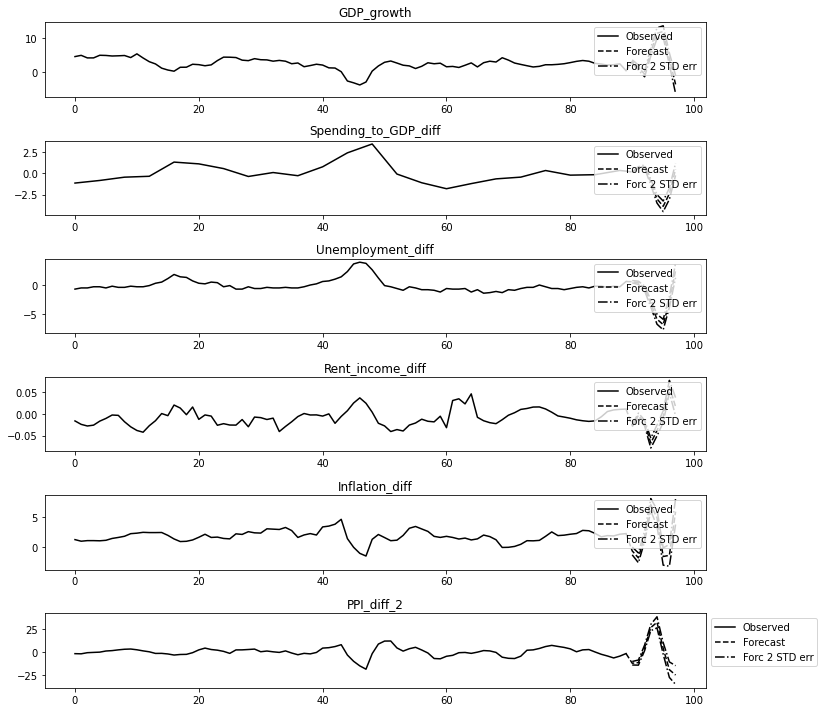

In [18]:
# plot forecast to visualize the above forecast along with asymptotic standard errors
results.plot_forecast(forecast_steps)
plt.tight_layout()
plt.legend(bbox_to_anchor=(1,1))
plt.show()

## Impulse response analysis
Describe the contemporaneous relationship between variables by identifying the shock to the multivariate system.

As we can see from the graphs below, the first differenced rent to income ratio (4th column) can hugely affect other variables. Whereas, GDP growth (1st column) and second differenced PPI (6th column) have mild effect on other variables.

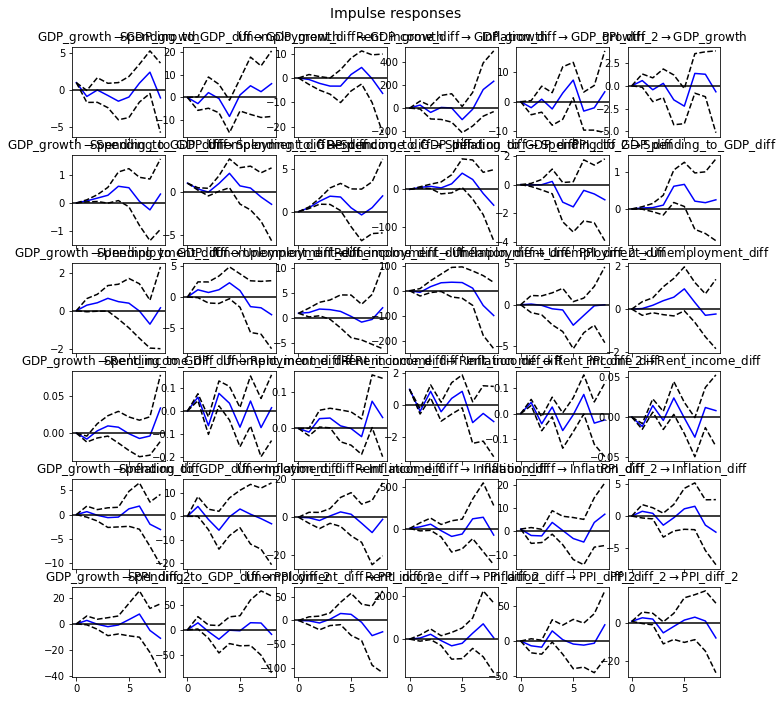

In [19]:
# plot impulse response function (IRF) for a specified lag length
# with asymptotic standard errors plotted at 95% significance level
irf = results.irf(forecast_steps)
irf.plot(orth=False)
plt.tight_layout()
plt.show()

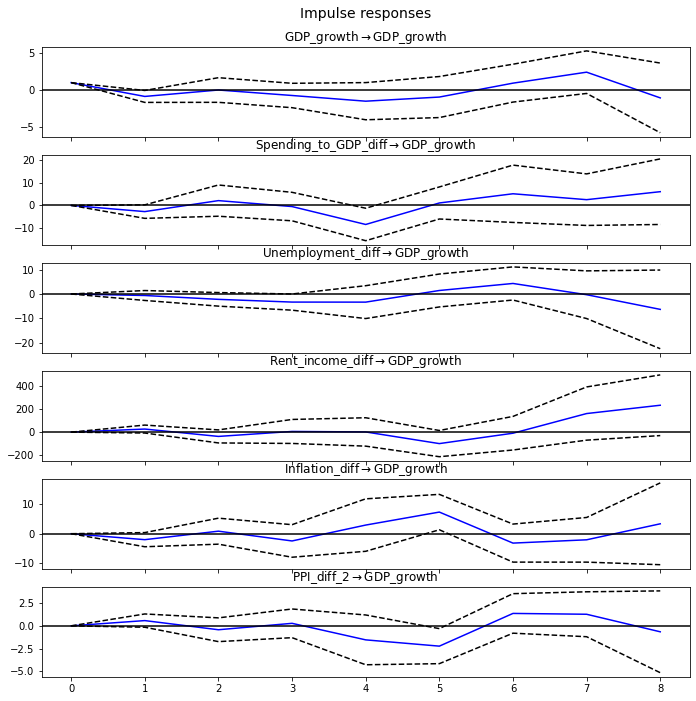

In [20]:
# check individual variable - a closer look to the 1st row above
irf.plot(response='GDP_growth')
plt.show()

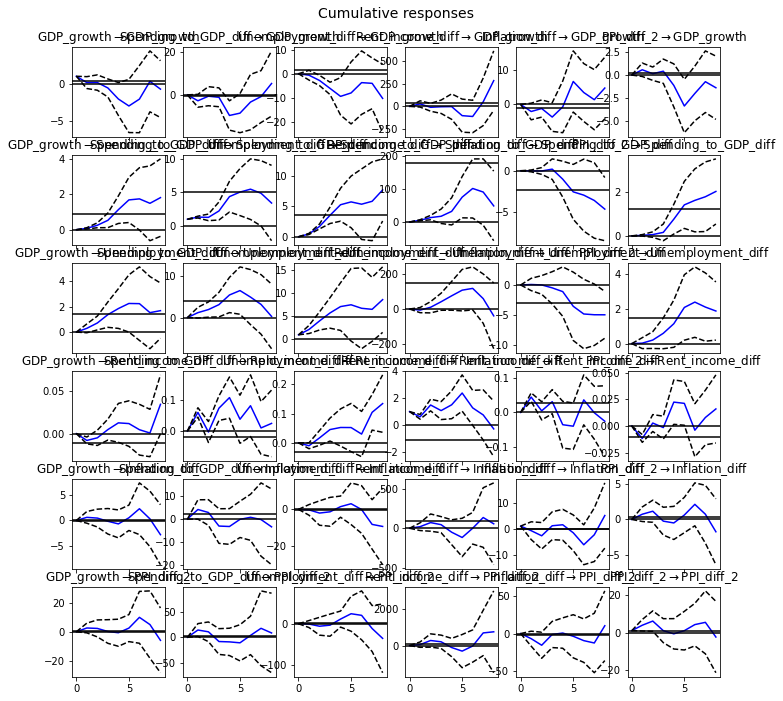

In [21]:
# cumulative effects
irf.plot_cum_effects(orth=False)
plt.show()

## Save model

In [22]:
import joblib
filepath = 'models/var_model.pkl'
joblib.dump(results, filepath)

['models/var_model.pkl']

In [23]:
df.to_csv('data/step4_forecasting.csv')